In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import numpy as np
import holidays
from datetime import datetime

In [2]:
trnsact_file = "trnsact.csv"

In [3]:
n = 1000
sample = pd.read_csv(trnsact_file, header=None, skiprows=lambda i: i % n != 0)
sample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,30.00,3500000,818,0
1,387,802,600,7900,526108628,2004-12-19,P,1,79.0,54.00,54.00,125100013,696,0
2,450,2307,950,2500,0,2005-07-17,P,1,6.0,3.99,3.99,903100004,844,0
3,497,8607,190,3600,374208521,2005-02-17,P,1,24.0,6.00,6.00,632500006,881,0
4,697,6402,740,1200,0,2005-07-21,P,1,34.0,34.00,34.00,395300008,190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120912,9999950,6604,520,9200,486901397,2005-07-29,P,1,14.0,14.00,14.00,233600184,281,0
120913,9999950,7303,810,1000,0,2005-06-11,P,1,13.5,13.50,13.50,892600116,281,0
120914,9999950,7907,900,2600,583100909,2005-04-12,P,1,13.5,13.50,13.50,254500060,281,0
120915,9999950,8404,950,1400,0,2004-08-25,P,1,13.5,13.50,13.50,925600151,281,0


In [4]:
sum(sample[9] != sample[10])

0

So column 9 and 10 are exactly the same, so we could drop one of them

In [5]:
sample.drop([10, 13], axis = 1, inplace = True)
sample

,0,1,2,3,4,5,6,7,8,9,11,12
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818
1,387,802,600,7900,526108628,2004-12-19,P,1,79.0,54.00,125100013,696
2,450,2307,950,2500,0,2005-07-17,P,1,6.0,3.99,903100004,844
3,497,8607,190,3600,374208521,2005-02-17,P,1,24.0,6.00,632500006,881
4,697,6402,740,1200,0,2005-07-21,P,1,34.0,34.00,395300008,190
...,...,...,...,...,...,...,...,...,...,...,...,...
120912,9999950,6604,520,9200,486901397,2005-07-29,P,1,14.0,14.00,233600184,281
120913,9999950,7303,810,1000,0,2005-06-11,P,1,13.5,13.50,892600116,281
120914,9999950,7907,900,2600,583100909,2005-04-12,P,1,13.5,13.50,254500060,281
120915,9999950,8404,950,1400,0,2004-08-25,P,1,13.5,13.50,925600151,281


In [6]:
sample.columns = ["SKU", "STORE", "REGISTER", "TRANNUM", "INTERID", "SALEDATE", "STYPE", "QUANTITY", "ORIGPRICE", "AMT", "SEQ", "MIC"]
sample

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818
1,387,802,600,7900,526108628,2004-12-19,P,1,79.0,54.00,125100013,696
2,450,2307,950,2500,0,2005-07-17,P,1,6.0,3.99,903100004,844
3,497,8607,190,3600,374208521,2005-02-17,P,1,24.0,6.00,632500006,881
4,697,6402,740,1200,0,2005-07-21,P,1,34.0,34.00,395300008,190
...,...,...,...,...,...,...,...,...,...,...,...,...
120912,9999950,6604,520,9200,486901397,2005-07-29,P,1,14.0,14.00,233600184,281
120913,9999950,7303,810,1000,0,2005-06-11,P,1,13.5,13.50,892600116,281
120914,9999950,7907,900,2600,583100909,2005-04-12,P,1,13.5,13.50,254500060,281
120915,9999950,8404,950,1400,0,2004-08-25,P,1,13.5,13.50,925600151,281


In [7]:
sample.dtypes

SKU            int64
STORE          int64
REGISTER       int64
TRANNUM        int64
INTERID        int64
SALEDATE      object
STYPE         object
QUANTITY       int64
ORIGPRICE    float64
AMT          float64
SEQ            int64
MIC            int64
dtype: object

### SKU

In [8]:
sample_sku = sample["SKU"].value_counts().reset_index()
sample_sku["index"] = sample_sku["index"].astype(str)
sample_sku

,index,SKU
0,4628597,535
1,4108011,312
2,3524026,271
3,5528349,240
4,3978011,208
...,...,...
86842,3516087,1
86843,3514878,1
86844,3514781,1
86845,3514491,1


In [9]:
sample.groupby("SKU")["AMT"].nunique().reset_index().sort_values("AMT")

,SKU,AMT
0,3,1
57028,6508564,1
57027,6508562,1
57026,6508488,1
57025,6508463,1
...,...,...
70109,8042644,7
62306,7136239,7
66192,7596135,8
79177,9086887,8


In [10]:
sample_sku["SKU"].describe()

count    86847.000000
mean         1.392299
std          3.767847
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        535.000000
Name: SKU, dtype: float64

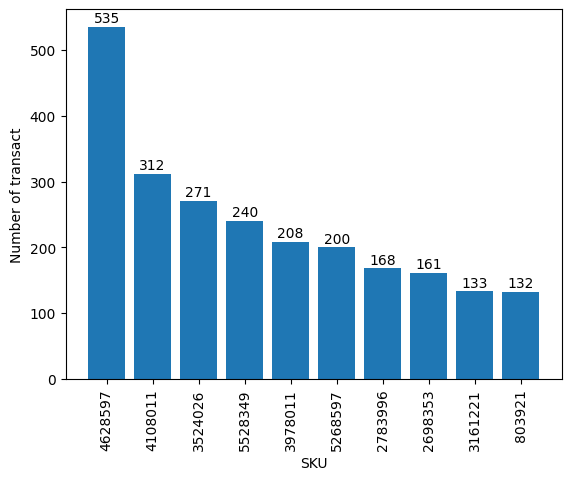

In [11]:
bars = plt.bar(sample_sku.head(10)["index"], sample_sku.head(10)["SKU"])
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 1), textcoords='offset points', ha='center', va='bottom')

plt.xticks(rotation=90)
plt.xlabel("SKU")
plt.ylabel("Number of transact")
plt.show();

### Store

In [12]:
sample_store = sample["STORE"].value_counts().reset_index()
sample_store["index"] = sample_store["index"].astype(str)
sample_store

,index,STORE
0,8402,949
1,2707,915
2,504,883
3,9103,851
4,1607,838
...,...,...
324,1804,107
325,1704,100
326,6209,91
327,7604,28


In [13]:
sample_store["STORE"].describe()

count    329.000000
mean     367.528875
std      156.408061
min       16.000000
25%      254.000000
50%      333.000000
75%      468.000000
max      949.000000
Name: STORE, dtype: float64

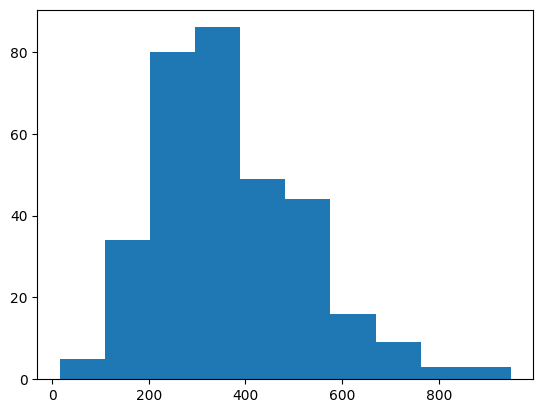

In [14]:
plt.hist(sample_store["STORE"]);

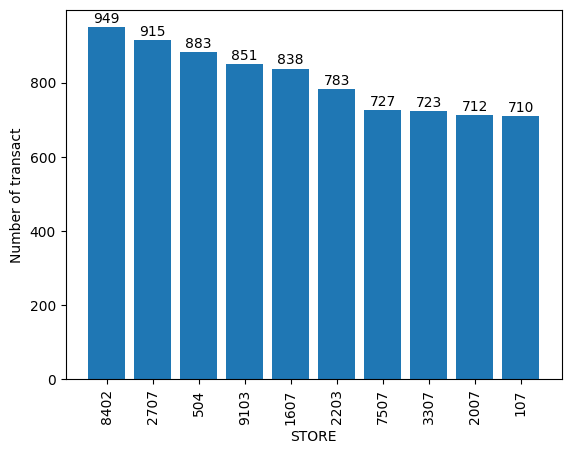

In [15]:
bars = plt.bar(sample_store.head(10)["index"], sample_store.head(10)["STORE"])
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 1), textcoords='offset points', ha='center', va='bottom')

plt.xticks(rotation=90)
plt.xlabel("STORE")
plt.ylabel("Number of transact")
plt.show();

### Stype

In [16]:
sample["STYPE"].value_counts()

P    111598
R      9319
Name: STYPE, dtype: int64

R represents return, P represents purchase

In [17]:
returns = sample[sample["STYPE"] == "R"]
returns

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC
19,3870,6803,511,3300,0,2004-08-28,R,1,49.0,49.00,815900172,20
27,4564,7507,200,2700,0,2005-05-08,R,1,0.0,17.37,100100012,1
34,6303,2309,320,2300,0,2004-11-19,R,1,28.0,28.00,207700049,310
48,7302,8409,620,500,0,2004-12-27,R,1,26.0,26.00,466300149,393
55,7425,7107,350,3700,0,2005-03-28,R,1,65.0,65.00,478100033,205
...,...,...,...,...,...,...,...,...,...,...,...,...
120875,9998282,404,40,4900,0,2004-12-29,R,1,50.0,19.99,193600117,20
120879,9998472,3403,320,700,948709897,2005-05-22,R,1,42.0,29.99,964300041,511
120883,9999102,4607,720,7400,0,2005-06-18,R,1,18.0,18.00,275600120,753
120901,9999950,302,710,2000,0,2004-08-01,R,1,13.5,13.50,23200078,281


In [18]:
purchases = sample[sample["STYPE"] == "P"]
purchases

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818
1,387,802,600,7900,526108628,2004-12-19,P,1,79.0,54.00,125100013,696
2,450,2307,950,2500,0,2005-07-17,P,1,6.0,3.99,903100004,844
3,497,8607,190,3600,374208521,2005-02-17,P,1,24.0,6.00,632500006,881
4,697,6402,740,1200,0,2005-07-21,P,1,34.0,34.00,395300008,190
...,...,...,...,...,...,...,...,...,...,...,...,...
120912,9999950,6604,520,9200,486901397,2005-07-29,P,1,14.0,14.00,233600184,281
120913,9999950,7303,810,1000,0,2005-06-11,P,1,13.5,13.50,892600116,281
120914,9999950,7907,900,2600,583100909,2005-04-12,P,1,13.5,13.50,254500060,281
120915,9999950,8404,950,1400,0,2004-08-25,P,1,13.5,13.50,925600151,281


### Quantity

In [19]:
sample["QUANTITY"].value_counts()

1    120917
Name: QUANTITY, dtype: int64

### Price

In [20]:
sample[sample["ORIGPRICE"] == 0]

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818
27,4564,7507,200,2700,0,2005-05-08,R,1,0.0,17.37,100100012,1
1344,107511,309,230,1500,0,2004-12-19,R,1,0.0,72.00,141400141,204
1737,140674,704,410,300,0,2005-07-25,P,1,0.0,9.00,978800006,823
1856,150925,9806,193,48500,72708937,2004-08-26,P,1,0.0,51.75,60800013,532
...,...,...,...,...,...,...,...,...,...,...,...,...
119238,9852339,3103,370,4600,0,2005-02-25,R,1,0.0,35.00,851400029,333
119880,9910023,1002,210,7400,549008339,2004-12-29,P,1,0.0,10.00,37700000,844
119885,9911394,403,370,2700,654000304,2004-09-30,P,1,0.0,7.37,494300037,862
120485,9963957,7703,580,1300,0,2004-11-07,R,1,0.0,17.25,805800018,658


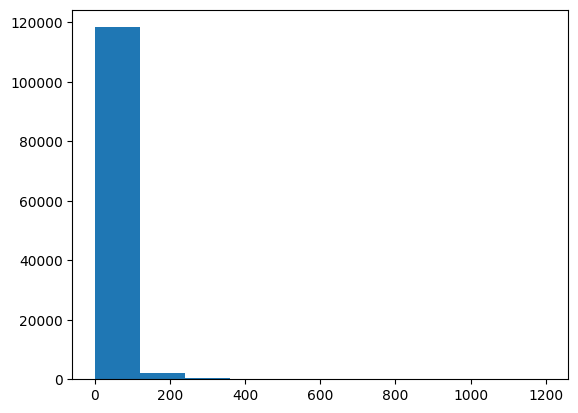

In [21]:
plt.hist(sample["ORIGPRICE"]);

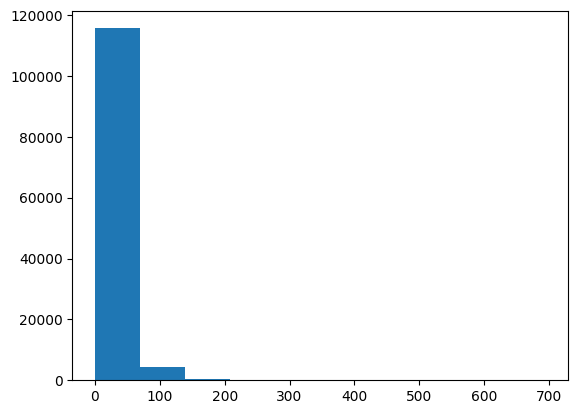

In [22]:
plt.hist(sample["AMT"]);

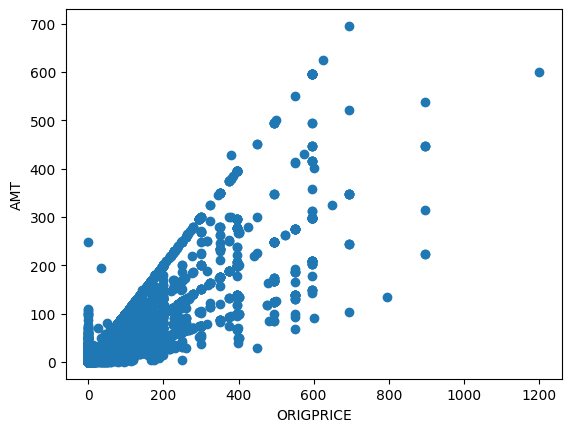

In [23]:
plt.scatter(sample["ORIGPRICE"], sample["AMT"])
plt.xlabel("ORIGPRICE")
plt.ylabel("AMT");

In [24]:
np.corrcoef(sample["ORIGPRICE"], sample["AMT"])

array([[1.        , 0.80320634],
       [0.80320634, 1.        ]])

In [25]:
np.corrcoef(purchases["ORIGPRICE"], purchases["AMT"])

array([[1.        , 0.80307145],
       [0.80307145, 1.        ]])

In [26]:
np.corrcoef(returns["ORIGPRICE"], returns["AMT"])

array([[1.        , 0.79403729],
       [0.79403729, 1.        ]])

In [27]:
sum(sample["ORIGPRICE"] < sample["AMT"])

265

In [28]:
sum(sample["ORIGPRICE"] == sample["AMT"])

57196

In [29]:
sum(sample["ORIGPRICE"] > sample["AMT"])

63456

In [30]:
sample["DISCOUNT"] = sample["AMT"] / sample["ORIGPRICE"]
sample

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC,DISCOUNT
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818,inf
1,387,802,600,7900,526108628,2004-12-19,P,1,79.0,54.00,125100013,696,0.683544
2,450,2307,950,2500,0,2005-07-17,P,1,6.0,3.99,903100004,844,0.665000
3,497,8607,190,3600,374208521,2005-02-17,P,1,24.0,6.00,632500006,881,0.250000
4,697,6402,740,1200,0,2005-07-21,P,1,34.0,34.00,395300008,190,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120912,9999950,6604,520,9200,486901397,2005-07-29,P,1,14.0,14.00,233600184,281,1.000000
120913,9999950,7303,810,1000,0,2005-06-11,P,1,13.5,13.50,892600116,281,1.000000
120914,9999950,7907,900,2600,583100909,2005-04-12,P,1,13.5,13.50,254500060,281,1.000000
120915,9999950,8404,950,1400,0,2004-08-25,P,1,13.5,13.50,925600151,281,1.000000


In [31]:
sample["DISCOUNT"].describe()

count    119730.0
mean          inf
std           NaN
min           0.0
25%           0.5
50%           0.8
75%           1.0
max           inf
Name: DISCOUNT, dtype: float64

In [32]:
sample[sample["DISCOUNT"].isna()]

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC,DISCOUNT
4066,341363,1104,540,1000,719009227,2005-08-25,P,1,0.0,0.0,754600145,772,NaN
4067,341363,9503,470,300,0,2005-08-20,P,1,0.0,0.0,361600156,772,NaN
6321,554630,3303,230,2400,208008842,2005-05-08,P,1,0.0,0.0,725700050,281,NaN
6646,578872,8607,491,300,0,2005-05-12,P,1,0.0,0.0,4000072,123,NaN
8734,759049,2209,470,4400,0,2005-06-11,P,1,0.0,0.0,471900118,502,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114633,9460294,4807,500,7900,707809876,2005-07-05,P,1,0.0,0.0,199100078,643,NaN
114634,9460294,4807,600,7700,16400810,2005-07-08,P,1,0.0,0.0,342200099,643,NaN
114635,9460294,8607,400,400,0,2005-07-11,P,1,0.0,0.0,698000070,643,NaN
114636,9460294,8707,150,2200,78002876,2005-07-16,P,1,0.0,0.0,74100152,643,NaN


In [33]:
sample["DISCOUNT"] = sample["DISCOUNT"].replace({np.inf: 9})

In [34]:
sample[sample["DISCOUNT"] > 1]

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,SEQ,MIC,DISCOUNT
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,3500000,818,9.000000
27,4564,7507,200,2700,0,2005-05-08,R,1,0.0,17.37,100100012,1,9.000000
966,72000,6104,360,900,0,2004-12-15,P,1,35.0,195.00,56900027,337,5.571429
1344,107511,309,230,1500,0,2004-12-19,R,1,0.0,72.00,141400141,204,9.000000
1737,140674,704,410,300,0,2005-07-25,P,1,0.0,9.00,978800006,823,9.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119238,9852339,3103,370,4600,0,2005-02-25,R,1,0.0,35.00,851400029,333,9.000000
119880,9910023,1002,210,7400,549008339,2004-12-29,P,1,0.0,10.00,37700000,844,9.000000
119885,9911394,403,370,2700,654000304,2004-09-30,P,1,0.0,7.37,494300037,862,9.000000
120485,9963957,7703,580,1300,0,2004-11-07,R,1,0.0,17.25,805800018,658,9.000000


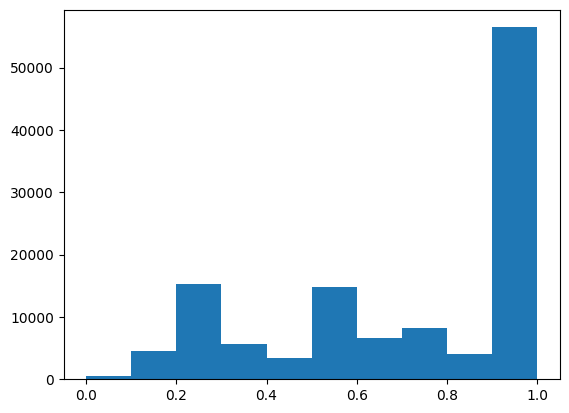

In [35]:
plt.hist(sample[sample["DISCOUNT"] <= 1]["DISCOUNT"]);

In [36]:
sample["SALEDATE"] = pd.to_datetime(sample["SALEDATE"])
sample["SALEDATE"]

0        2005-01-18
1        2004-12-19
2        2005-07-17
3        2005-02-17
4        2005-07-21
            ...    
120912   2005-07-29
120913   2005-06-11
120914   2005-04-12
120915   2004-08-25
120916   2005-02-21
Name: SALEDATE, Length: 120917, dtype: datetime64[ns]

In [37]:
def is_holiday(date):
    us_holidays = holidays.US()
    return date in us_holidays

sample['is_holiday'] = sample['SALEDATE'].apply(is_holiday).astype(int)

In [38]:
def get_weekday_name(date):
    return date.weekday()
sample['weekday'] = sample['SALEDATE'].apply(get_weekday_name).astype(int)

In [39]:
sample["weekend"] = (sample['weekday'] >= 5).astype(int)

In [40]:
sample["discount_flag"] = (sample["DISCOUNT"] < 1).astype(int)

When origprice and amt are all 0, DISCOUNT is null. Since there is no discount, set as 1.

In [41]:
sample["DISCOUNT"] = sample["DISCOUNT"].fillna(1)

In [42]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120917 entries, 0 to 120916
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   SKU            120917 non-null  int64         
 1   STORE          120917 non-null  int64         
 2   REGISTER       120917 non-null  int64         
 3   TRANNUM        120917 non-null  int64         
 4   INTERID        120917 non-null  int64         
 5   SALEDATE       120917 non-null  datetime64[ns]
 6   STYPE          120917 non-null  object        
 7   QUANTITY       120917 non-null  int64         
 8   ORIGPRICE      120917 non-null  float64       
 9   AMT            120917 non-null  float64       
 10  SEQ            120917 non-null  int64         
 11  MIC            120917 non-null  int64         
 12  DISCOUNT       120917 non-null  float64       
 13  is_holiday     120917 non-null  int64         
 14  weekday        120917 non-null  int64         
 15  

In [43]:
sample_purchase = purchases.groupby(["SALEDATE"])["AMT"].sum().reset_index()
sample_purchase.head(20)

,SALEDATE,AMT
0,2004-08-01,4957.92
1,2004-08-02,4040.82
2,2004-08-03,4059.58
3,2004-08-04,4717.15
4,2004-08-05,5283.94
5,2004-08-06,7351.14
6,2004-08-07,9428.90
7,2004-08-08,6082.90
8,2004-08-09,4359.06
9,2004-08-10,4699.13


In [44]:
sample_return = returns.groupby(["SALEDATE"])["AMT"].sum().reset_index()
sample_return

,SALEDATE,AMT
0,2004-08-01,400.63
1,2004-08-02,488.26
2,2004-08-03,424.87
3,2004-08-04,446.70
4,2004-08-05,478.45
...,...,...
384,2005-08-23,542.41
385,2005-08-24,966.08
386,2005-08-25,1051.45
387,2005-08-26,1201.49


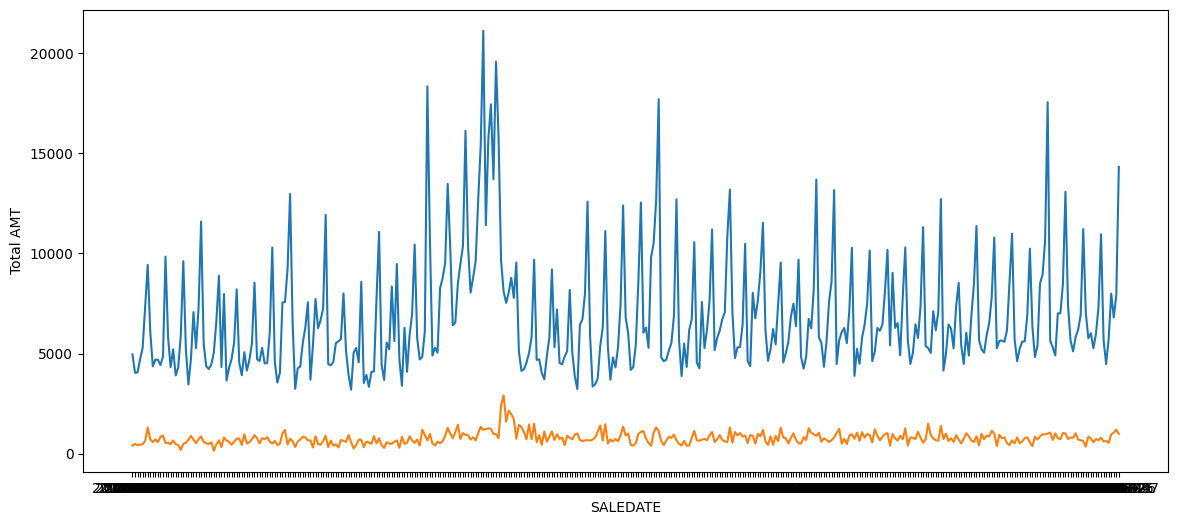

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(sample_purchase["SALEDATE"], sample_purchase["AMT"])
plt.plot(sample_return["SALEDATE"], sample_return["AMT"])
plt.xlabel("SALEDATE")
plt.ylabel("Total AMT");

Seasonality: weekends, Christmas

Store include strinfo and state

In [46]:
store = pd.read_pickle("store.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'store.pkl'

In [ ]:
df = sample.merge(store, left_on = "STORE", right_on = "STORE")
df

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,...,weekday,weekend,discount_flag,CITY,STATE,ZIP,State,State Code,Region,Division
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,...,1,0,0,TAMPA,FL,33612,Florida,FL,South,South Atlantic
1,47845,202,230,2800,0,2005-07-30,P,1,59.0,20.65,...,5,1,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic
2,66370,202,360,700,0,2005-06-16,P,1,89.5,44.75,...,3,0,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic
3,70148,202,230,3100,0,2005-08-06,P,1,44.0,44.00,...,5,1,0,TAMPA,FL,33612,Florida,FL,South,South Atlantic
4,98327,202,80,7700,0,2005-07-23,P,1,6.0,1.50,...,5,1,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120912,7700021,5703,160,600,0,2004-09-06,P,1,70.0,34.99,...,0,0,1,CINCINNATI,OH,45249,Ohio,OH,Midwest,East North Central
120913,8956048,5703,170,6100,0,2004-11-06,P,1,3.0,3.00,...,5,1,0,CINCINNATI,OH,45249,Ohio,OH,Midwest,East North Central
120914,9252157,5703,160,700,0,2004-08-21,P,1,15.0,11.25,...,5,1,1,CINCINNATI,OH,45249,Ohio,OH,Midwest,East North Central
120915,9417376,5703,170,8300,0,2005-04-08,P,1,9.0,3.37,...,4,0,1,CINCINNATI,OH,45249,Ohio,OH,Midwest,East North Central


In [ ]:
skst = pd.read_pickle("skst.pkl")

In [ ]:
df = df.merge(skst, on = ["SKU", "STORE"])
df

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORIGPRICE,AMT,...,discount_flag,CITY,STATE,ZIP,State,State Code,Region,Division,COST,RETAIL
0,3,202,290,1100,326708721,2005-01-18,P,1,0.0,30.00,...,0,TAMPA,FL,33612,Florida,FL,South,South Atlantic,123.36,440.00
1,47845,202,230,2800,0,2005-07-30,P,1,59.0,20.65,...,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic,26.85,29.50
2,66370,202,360,700,0,2005-06-16,P,1,89.5,44.75,...,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic,44.75,9.99
3,70148,202,230,3100,0,2005-08-06,P,1,44.0,44.00,...,0,TAMPA,FL,33612,Florida,FL,South,South Atlantic,20.68,44.00
4,98327,202,80,7700,0,2005-07-23,P,1,6.0,1.50,...,1,TAMPA,FL,33612,Florida,FL,South,South Atlantic,2.12,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68465,8838472,4903,400,1300,927009885,2005-05-28,P,1,44.0,29.99,...,1,MOLINE,IL,61265,Illinois,IL,Midwest,East North Central,18.50,11.00
68466,9337799,4903,450,1800,0,2005-04-02,P,1,21.0,21.00,...,0,MOLINE,IL,61265,Illinois,IL,Midwest,East North Central,12.60,21.00
68467,9600038,4903,200,700,456309358,2005-06-25,P,1,39.0,19.99,...,1,MOLINE,IL,61265,Illinois,IL,Midwest,East North Central,14.50,14.99
68468,9718901,4903,260,1500,0,2005-07-11,P,1,14.0,7.00,...,1,MOLINE,IL,61265,Illinois,IL,Midwest,East North Central,6.50,3.50


Join deptinfo in the future

In [ ]:
df["return"] = (df["STYPE"] == "R").astype(int)

In [ ]:
prices = df[["ORIGPRICE", "AMT", "COST", "RETAIL"]]
prices

,ORIGPRICE,AMT,COST,RETAIL
0,0.0,30.00,123.36,440.00
1,59.0,20.65,26.85,29.50
2,89.5,44.75,44.75,9.99
3,44.0,44.00,20.68,44.00
4,6.0,1.50,2.12,1.50
...,...,...,...,...
68465,44.0,29.99,18.50,11.00
68466,21.0,21.00,12.60,21.00
68467,39.0,19.99,14.50,14.99
68468,14.0,7.00,6.50,3.50


In [ ]:
prices.corr()

,ORIGPRICE,AMT,COST,RETAIL
ORIGPRICE,1.000000,0.830234,0.960186,0.787525
AMT,0.830234,1.000000,0.841752,0.848028
COST,0.960186,0.841752,1.000000,0.825152
RETAIL,0.787525,0.848028,0.825152,1.000000


Probably do not need skst

In [ ]:
prices.describe()

,ORIGPRICE,AMT,COST,RETAIL
count,68470.000000,68470.000000,68470.000000,68470.000000
mean,34.007426,24.627914,14.942023,20.646922
std,38.187024,26.554115,16.343516,25.656455
min,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.990000,6.900000,8.000000
50%,24.000000,18.000000,11.100000,15.000000
75%,44.000000,30.000000,18.250000,24.500000
max,895.000000,695.000000,390.000000,695.000000


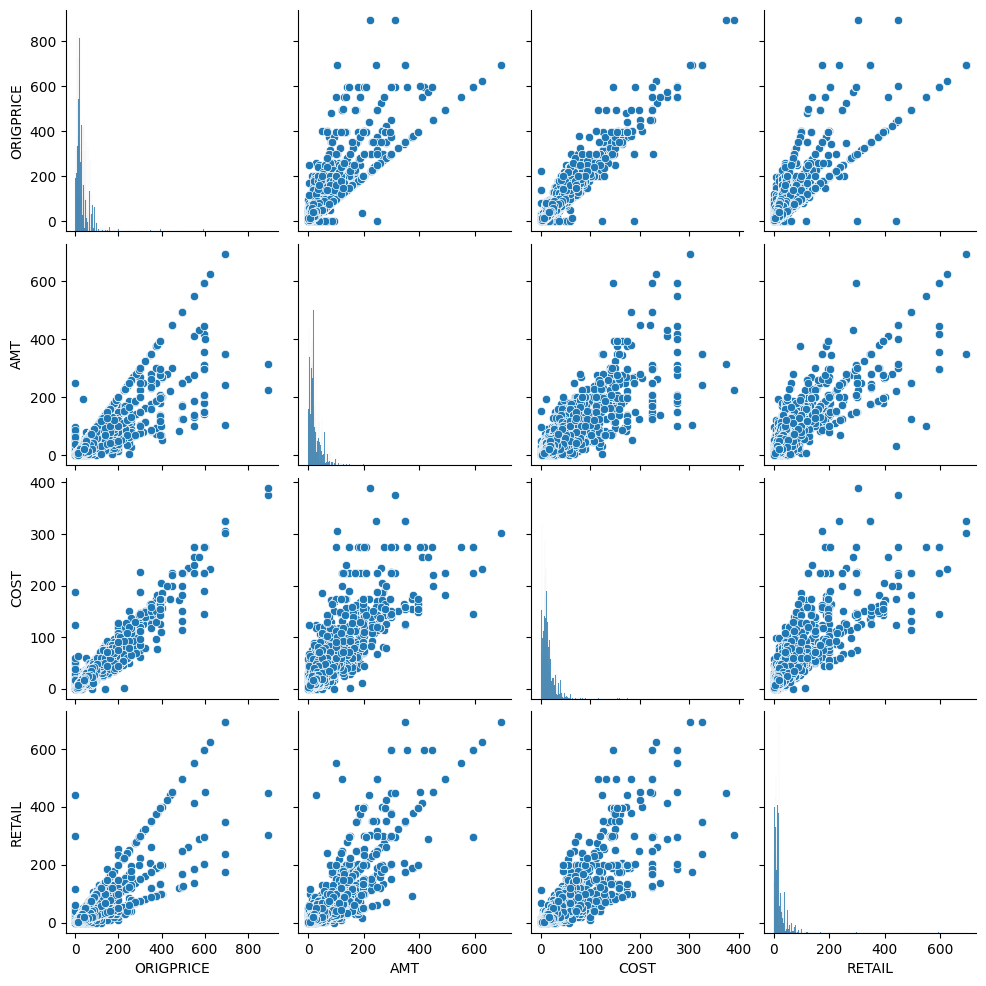

In [ ]:
import seaborn as sns
sns.pairplot(prices);

In [ ]:
df["first3"] = df["ZIP"].astype(str).str[:3]
df["first3"].value_counts()

750    1239
852    1216
770    1210
700    1145
782    1114
       ... 
331      97
748      92
832      91
922      72
612      62
Name: first3, Length: 212, dtype: int64

In [ ]:
df = pd.get_dummies(df, columns=['STATE', "Region"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68470 entries, 0 to 68469
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SKU             68470 non-null  int64         
 1   STORE           68470 non-null  int64         
 2   REGISTER        68470 non-null  int64         
 3   TRANNUM         68470 non-null  int64         
 4   INTERID         68470 non-null  int64         
 5   SALEDATE        68470 non-null  datetime64[ns]
 6   STYPE           68470 non-null  object        
 7   QUANTITY        68470 non-null  int64         
 8   ORIGPRICE       68470 non-null  float64       
 9   AMT             68470 non-null  float64       
 10  SEQ             68470 non-null  int64         
 11  MIC             68470 non-null  int64         
 12  DISCOUNT        68470 non-null  float64       
 13  is_holiday      68470 non-null  int64         
 14  weekday         68470 non-null  int64         
 15  we

VIF is better when using states instead of regions

In [ ]:
X = df.iloc[:, [8, 9, 12, 13, 14, 15, 16] + list(range(25, 54))]

In [ ]:
X[["is_holiday", "weekday", "weekend"]].corr()

,is_holiday,weekday,weekend
is_holiday,1.000000,-0.145782,-0.085039
weekday,-0.145782,1.000000,0.780670
weekend,-0.085039,0.780670,1.000000


weekday (0-6) and weekend (0/1) has higher correlation, low correlation with is_holiday

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_result = calculate_vif(X)

print(vif_result)

         Variable       VIF
0       ORIGPRICE  5.083629
1             AMT  5.201633
2        DISCOUNT  2.318728
3      is_holiday  1.025119
4         weekday  2.610283
5         weekend  2.570244
6   discount_flag  2.225608
7        STATE_AL  1.849020
8        STATE_AR  1.777763
9        STATE_AZ  2.341604
10       STATE_CA  1.201541
11       STATE_CO  1.748617
12       STATE_FL  4.513756
13       STATE_GA  1.846444
14       STATE_IA  1.244173
15       STATE_ID  1.139082
16       STATE_IL  1.134205
17       STATE_IN  1.128839
18       STATE_KS  1.679542
19       STATE_KY  1.754071
20       STATE_LA  2.330233
21       STATE_MO  1.917148
22       STATE_MS  1.290335
23       STATE_MT  1.173715
24       STATE_NC  1.764353
25       STATE_NE  1.323031
26       STATE_NM  1.457383
27       STATE_NV  1.407075
28       STATE_OH  2.197969
29       STATE_OK  1.803958
30       STATE_SC  1.504622
31       STATE_TN  1.905084
32       STATE_TX  6.043119
33       STATE_UT  1.375562
34       STATE_VA  1

In [ ]:
y = df["return"]

In [ ]:
y.value_counts()

0    63350
1     5120
Name: return, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

0    63350
1    12670
Name: return, dtype: int64

In [ ]:
model = LogisticRegression()
model.fit(X, y)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model.predict(X)

In [ ]:
accuracy_score(y, y_pred)

0.9248283919964948

In [ ]:
confusion_matrix(y, y_pred)

array([[63302,    48],
       [ 5099,    21]])

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     63350
           1       0.30      0.00      0.01      5120

    accuracy                           0.92     68470
   macro avg       0.61      0.50      0.48     68470
weighted avg       0.88      0.92      0.89     68470



Connection

In [ ]:
# Connect to an existing database
conn = psycopg2.connect(user="ksk4532",
                        password="Weiwei@259000",
                        host="pg.analytics.northwestern.edu",
                        port="5432",
                        database="everything2023")


#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("SELECT version();")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)

In [ ]:
psql.read_sql("""
SELECT \"STORE\"
FROM group_6.\"TRNSACT\" AS t 
LIMIT 10
""", conn)

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,STORE
0,202
1,202
2,303
3,709
4,802
5,1202
6,1204
7,1304
8,1703
9,1703


In [ ]:
df_sql = psql.read_sql("""
SELECT * 
FROM group_6.\"TRNSACT\" AS trn 
JOIN group_6.\"STRINFO\" AS str 
ON trn.\"STORE\" = str.\"STORE\"
JOIN group_6.\"SKUINFO\" AS sku
ON trn.\"SKU\" = sku.\"SKU\"
""", conn)
df_sql.head()

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
cursor.close()
conn.close()

In [ ]:
df_sql

,SKU,STORE,REGISTER,TRANNUM,INTERID,SALEDATE,STYPE,QUANTITY,ORGPRICE,AMT,...,SEQ,MIC,STORE,CITY,STATE,ZIP,SKU,STORE,COST,RETAIL
0,3,202,290,01100,326708721,2005-01-18,P,1.0,0.0,30.00,...,003500000,818,202,TAMPA,FL,33612,3,202,123.36,440.0
1,3,202,540,02700,326708721,2005-01-29,R,1.0,0.0,30.00,...,015200000,818,202,TAMPA,FL,33612,3,202,123.36,440.0
2,3,802,660,00400,000000000,2005-08-09,P,1.0,440.0,30.00,...,004700000,599,802,CLEARWATER,FL,33761,3,802,123.36,440.0
3,3,1202,400,02100,000000000,2004-11-11,P,1.0,0.0,30.00,...,008600000,999,1202,SARASOTA,FL,34239,3,1202,123.36,440.0
4,3,1304,160,03500,000000000,2004-08-07,P,1.0,0.0,30.00,...,011400000,990,1304,FORT SMITH,AR,72903,3,1304,123.36,440.0
5,3,1703,30,00200,000000000,2005-08-09,P,1.0,440.0,30.00,...,004800000,999,1703,ST. JOSEPH,MO,64506,3,1703,123.36,440.0
6,3,1703,30,02400,000000000,2005-08-24,R,1.0,440.0,30.00,...,010100000,999,1703,ST. JOSEPH,MO,64506,3,1703,123.36,440.0
7,3,1707,160,01100,016200776,2005-07-20,P,1.0,440.0,1.99,...,007200000,931,1707,DALLAS,TX,75237,3,1707,123.36,440.0
8,3,2007,120,05100,048008215,2004-12-28,P,1.0,0.0,4.50,...,022400000,931,2007,SAN ANTONIO,TX,78216,3,2007,123.36,440.0
9,3,2007,120,05100,048008215,2004-12-28,P,1.0,0.0,4.50,...,022500000,931,2007,SAN ANTONIO,TX,78216,3,2007,123.36,440.0


- Logistics Regression
- Random Forest
- SVM
- Boosting
- KNN